In [1]:
%load_ext autoreload
%autoreload 

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from suite3d import nbtools as nbui

In [48]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'AH012',
    'date' :          '2024-07-27',
    'expnum' :         [13,14,]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21])[n.array([6,7,8,9,10,11,12])],
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 7,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str + 'subset', tifs = tifs[:20],
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset already exists
Loading job directory for AH012_2024-07-27_13-14subset in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [49]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/AH012/2024-07-27/13/2024-07-27_13_AH012_2P_00001_00005.tif
    Loaded file into shared memory in 25.45 sec
    Workers completed in 2.05 sec
    Total time: 27.49 sec
      Loading /mnt/zortex-subjects/AH012/2024-07-27/13/2024-07-27_13_AH012_2P_00001_00009.tif
    Loaded file into shared memory in 27.68 sec
    Workers completed in 2.04 sec
    Total time: 29.73 sec
      Loading /mnt/zortex-subjects/AH012/2024-07-27/13/2024-07-27_13_AH012_2P_00001_00013.tif
    Loaded file into shared memory in 31.30 sec
    Workers completed in 1.79 sec
    Total time: 33.09 sec
      Loading /mnt/zortex-subjects/AH012/2024-07-27/13/2024-07-27_13_AH012_2P_00001_00017.tif
    Loaded file into shared memory in 39.5

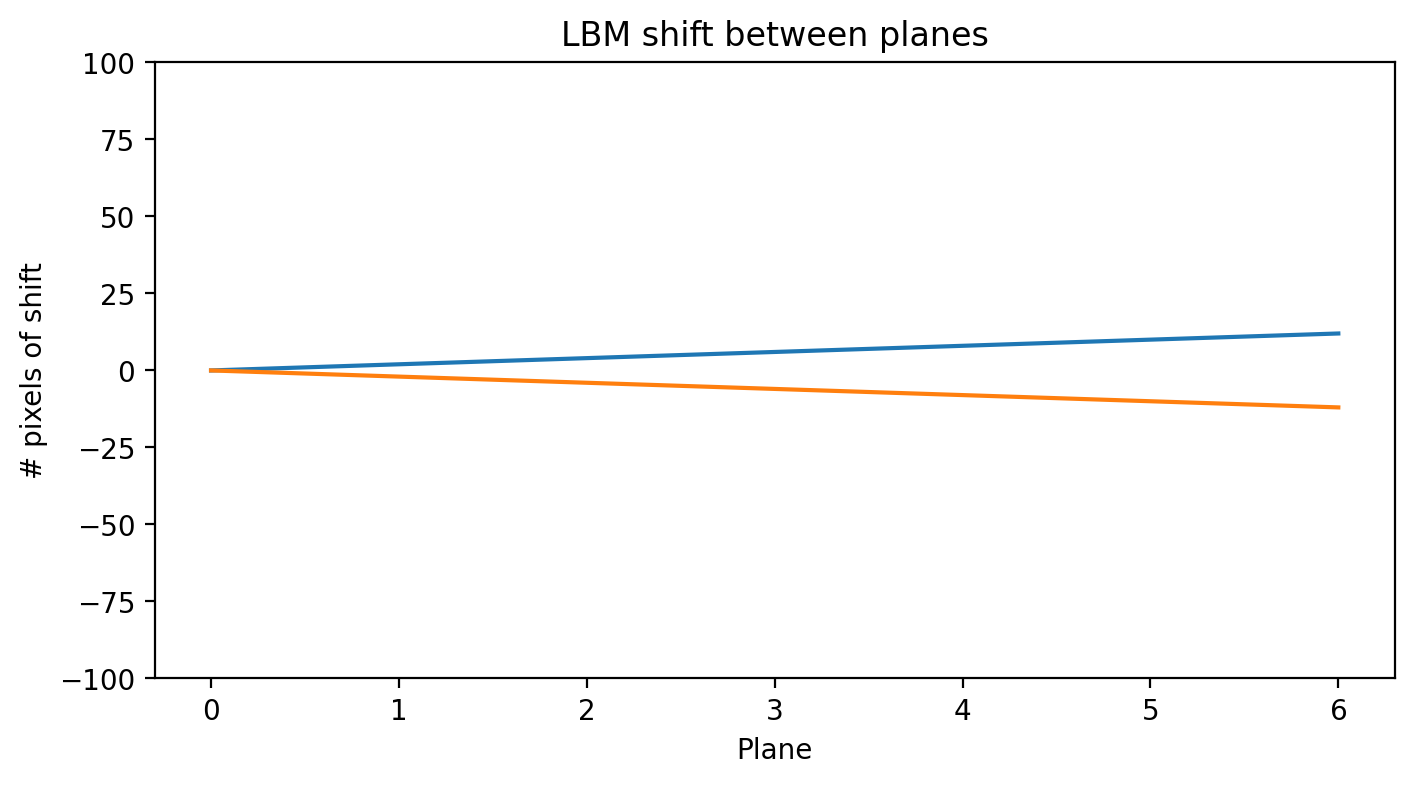

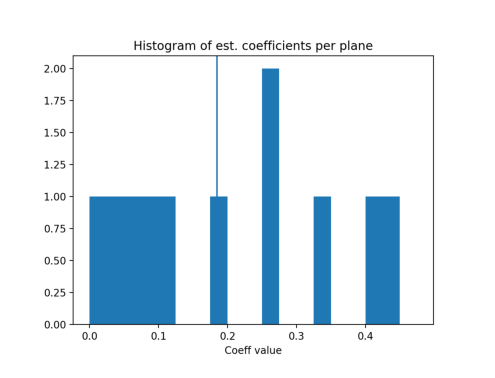

In [50]:
%%time
job.run_init_pass()

In [51]:
img3d = job.load_summary()['ref_img_3d']

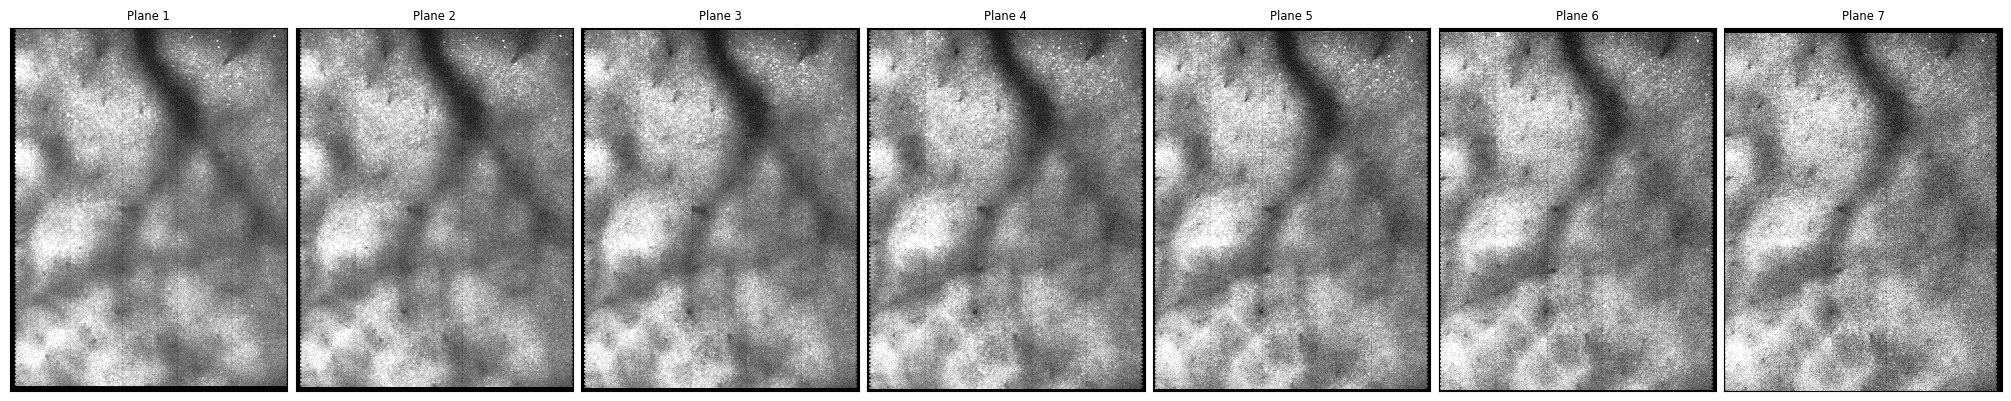

In [52]:
tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,10))

In [53]:
%%time
job.register(tifs=tifs[-8:])

      Found dir /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Overriding fuse shift value to 7
   Not clipping frames for registration
Will analyze 8 tifs in 8 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 099.311 GB, Virtual Available: 419.571 GB, Virtual Used: 083.625 GB, Swap Used: 015.686 GB
Loading Batch 0 of 7
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00001.tif
    Loaded file into shared memory in 38.94 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.67 sec
    Total time: 40.60 sec
   Loaded 1 files, total 0.84 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 100.244 GB, Virtual Available: 418.637 GB, Virtual Used: 084.559 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 101.089 GB, Virtual Available: 417.792 GB, Virtual Used: 085.404 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 100.174 GB, Virtual Available: 418.707 GB, Virtual Used: 084.489 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 100.174 GB, Virtual Available: 418.707 GB, Virtual Used: 084.489 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00002.tif
   Completed rigid reg on batch in :1.9371416568756104s
   Shifted the mov in: 0.5164616107940674s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 1.86 sec
    Total time: 40.10 sec
   Loaded 1 files, total 0.84 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 103.561 GB, Virtual Available: 415.320 GB, Virtual Used: 087.875 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 101.903 GB, Virtual Available: 416.978 GB, Virtual Used: 086.217 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 101.056 GB, Virtual Available: 417.825 GB, Virtual Used: 085.370 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00003.tif
         After IO thread launch:Total Used: 101.056 GB, Virtual Available: 417.825 GB, Virtual Used: 085.370 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
   Completed rigid reg on batch in :1.9564850330352783s
   Shifted the mov in: 0.5341737270355225s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.09 sec
    Total time: 39.38 sec
   Loaded 1 files, total 0.84 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 103.600 GB, Virtual Available: 415.282 GB, Virtual Used: 087.914 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 101.942 GB, Virtual Available: 416.939 GB, Virtual Used: 086.256 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 101.098 GB, Virtual Available: 417.783 GB, Virtual Used: 085.412 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 101.098 GB, Virtual Available: 417.783 GB, Virtual Used: 085.412 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00004.tif
   Completed rigid reg on batch in :1.9576032161712646s
   Shifted the mov in: 0.5243914127349854s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.16 sec
    Total time: 37.47 sec
   Loaded 1 files, total 0.84 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 103.796 GB, Virtual Available: 415.085 GB, Virtual Used: 088.111 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 102.138 GB, Virtual Available: 416.743 GB, Virtual Used: 086.453 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 101.295 GB, Virtual Available: 417.586 GB, Virtual Used: 085.609 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 101.295 GB, Virtual Available: 417.586 GB, Virtual Used: 085.609 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00005.tif
      Loaded batch of size (7, 100, 900, 720)
   Completed rigid reg on batch in :1.9817783832550049s
   Shifted the mov in: 0.5572934150695801s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.58 sec
    Total time: 37.90 sec
   Loaded 1 files, total 0.84 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 103.693 GB, Virtual Available: 415.188 GB, Virtual Used: 088.008 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 102.036 GB, Virtual Available: 416.845 GB, Virtual Used: 086.350 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 101.190 GB, Virtual Available: 417.691 GB, Virtual Used: 085.505 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 101.190 GB, Virtual Available: 417.691 GB, Virtual Used: 085.505 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00006.tif
   Completed rigid reg on batch in :1.9851462841033936s
   Shifted the mov in: 0.534111499786377s
         After all GPU Batches:Tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.26 sec
    Total time: 38.52 sec
   Loaded 1 files, total 0.84 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 103.705 GB, Virtual Available: 415.176 GB, Virtual Used: 088.019 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 102.047 GB, Virtual Available: 416.835 GB, Virtual Used: 086.361 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 101.197 GB, Virtual Available: 417.684 GB, Virtual Used: 085.512 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 101.197 GB, Virtual Available: 417.684 GB, Virtual Used: 085.512 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00007.tif
   Completed rigid reg on batch in :1.9876000881195068s
   Shifted the mov in: 0.5482895374298096s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.32 sec
    Total time: 35.10 sec
   Loaded 1 files, total 0.84 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 103.755 GB, Virtual Available: 415.126 GB, Virtual Used: 088.070 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 102.089 GB, Virtual Available: 416.792 GB, Virtual Used: 086.403 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 101.241 GB, Virtual Available: 417.640 GB, Virtual Used: 085.555 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 101.241 GB, Virtual Available: 417.640 GB, Virtual Used: 085.555 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 100, 900, 720)
      Loading /mnt/zortex-subjects/AH012/2024-07-27/14/2024-07-27_14_AH012_2P_00001_00008.tif
   Completed rigid reg on batch in :1.9960811138153076s
   Shifted the mov in: 0.5709748268127441s
         After all GPU Batches:To

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.27 sec
    Total time: 31.72 sec
   Loaded 1 files, total 0.71 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 103.593 GB, Virtual Available: 415.288 GB, Virtual Used: 087.908 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 101.927 GB, Virtual Available: 416.954 GB, Virtual Used: 086.242 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 101.216 GB, Virtual Available: 417.665 GB, Virtual Used: 085.530 GB, Swap Used: 015.686 GB
      Loaded batch of size (7, 84, 900, 720)
   Completed rigid reg on batch in :1.700401782989502s
   Shifted the mov in: 0.4375314712524414s
         After all GPU Batches:Total Used: 104.006 GB, Virtual Available: 414.876 GB, Virtual Used: 088.320 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (7, 84, 912, 697) to /mnt/md0/runs/s3d-AH012_2024-07-27_13-14subset/registered_fused_data/fused_reg_data0007.npy
         S

In [54]:
reg = job.load_registration_results()

In [55]:
pixshift = n.concatenate(reg['sub_pixel_shifts'])

In [58]:
ground_truth = '/mnt/md0/runs/pub-figs/zshift_ground_truth-AH012-2024-07-27.csv'

In [61]:
import pandas as pd

df = pd.read_csv(ground_truth)

In [66]:
dt = 3
zshifts = df['zshift'] - zshifts[0]
zshift_ts = n.arange(zshifts.shape[0]) * dt

In [70]:
pixshift
pixshift_ts = n.arange(pixshift.shape[0]) / job.params['fs']

In [73]:
pixshift_ts.max()

190.2166611240439

In [74]:
zshift_ts.max()

108

Text(0, 0.5, 'Axial shift')

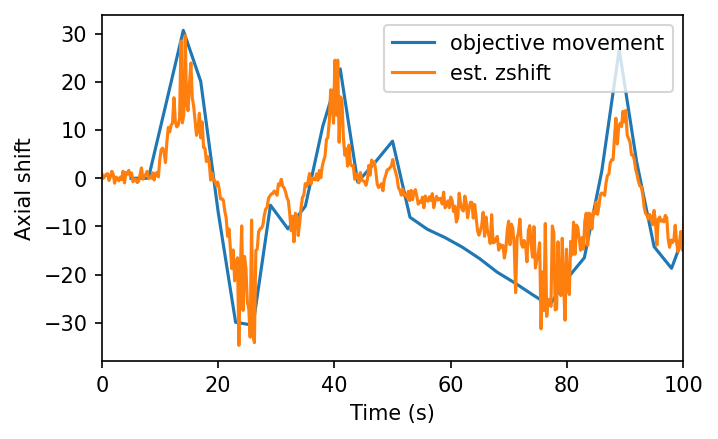

In [88]:
plt.figure(figsize=(5,3),dpi=150)
plt.plot(zshift_ts + 5, zshifts, label='objective movement')
plt.plot(pixshift_ts, 40 * pixshift[:,0], label='est. zshift')
plt.xlim(0,100)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Axial shift")

Text(0, 0.5, 'Axial shift')

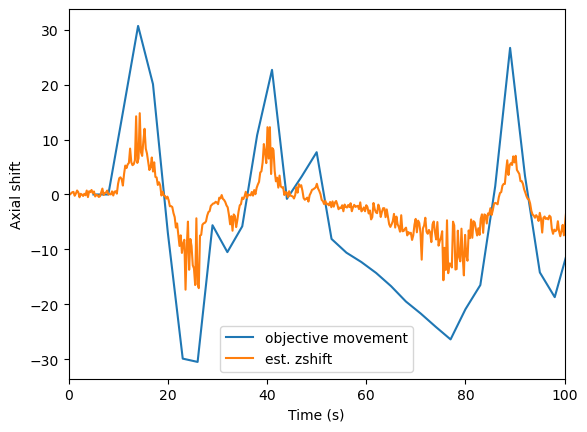

In [84]:
plt.plot(zshift_ts + 5, zshifts, label='objective movement')
plt.plot(pixshift_ts, 20 * pixshift[:,0], label='est. zshift')
plt.xlim(0,100)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Axial shift")

In [44]:
mov = job.get_registered_movie()[5].compute()